# Assignment 1
### Group 143
- Martin Madsen (marmad@stud.ntnu.no) 
- Sondre Bergum (sondreab@stud.ntu.no)  
  
This assignment is based on the example provided as an assignment lecture for the beer rating classification. We prompted a student assistant whether it was allowed to use this as a base for the assignment, and received positive response. We have made changes to several of the functions to make them suit out problem.

### Task 1.1: Derive the gradient for Logistic Regression
Show that 
$$
-\frac{\partial E^n(w)}{\partial w_j} = (t^n - y^n)x_j^n
$$
using 
$$
\frac{\partial g_w^n}{\partial w_j} = x_j^n g_w^n (1-g_w^n)
$$

where 

$$
E(w) = -\frac{1}{N} \sum_{n=1}^{N} t^n \ln(y^n) + (1 - t^n) \ln(1 - y^n)
\\
y^n = g_w^n
$$

Answer:
$$
-\frac{\partial E^n(w)}{\partial w_j} = -\frac{\partial E^n(w)}{\partial g_w^n}\frac{\partial g_w^n}{\partial w_j}
$$
  
$$
-\frac{\partial E^n(w)}{\partial g_w^n} = \frac{\partial}{\partial g_w^n}[t^n \ln(g_w^n) + (1 - t^n) \ln(1 - g_w^n)] \\
= t^n \frac{\partial}{\partial g_w^n}[\ln(g_w^n)] + (1 - t^n) \frac{\partial}{\partial g_w^n}[\ln(1 - g_w^n)] \\
= t^n \frac{1}{g_w^n} - (1 - t^n) \frac{1}{1 - g_w^n}
$$

$$
-\frac{\partial E^n(w)}{\partial g_w^n}\frac{\partial g_w^n}{\partial w_j} = [t^n \frac{1}{g_w^n} - (1 - t^n) \frac{1}{1 - g_w^n}][x_j^n g_w^n (1-g_w^n)] \\
= x_j^n (t^n - y^n)
$$

### Task 1.2
Found at the end
![](task1.2.jpg)

## Task 2

### Task 2.1
#### a)
The plot for the losses can be found as output from Ipython cell nr [14].
This is generated using linear regression with annealing learning rate and early stopping. The assignment text stated we were looking for a smooth curve, but this seemed hard to achieve using annealing learning rate. Without it however, using a very low and static learning rate (about $\alpha = 0.000001$) smooth curves were achievable. This is probably due to the tuning of the annealing equation and the hyperparameters it's dependent upon.

#### b)
The plot for percent correctly classified samples can be found as the output of the Ipython cell nr [15].
There is a typo in the assignment text. As we changed the $Y_{train}$ labels for the "2"s to "1" and "3"s to 0, the classification is correct for "2"s if output is $\geq 0.5$ and correct for "3" if output $< 0.5$. (not $\leq 0.5$ for "2" like in the text).

### Task 2.2
#### a)
$$
w_{t+1} = w_t - \alpha \sum_{n=1}^{N} \frac{\partial J^n(w)}{\partial w}
$$
where
$$
J(w) = E(w) + \lambda C(w)
$$
and for $L_2$ regularization
$$
C(w) = ||w||^2 = w^T w
$$
so
$$
\frac{\partial C(w)}{\partial w} = 2 w
$$

The regularized cross entorpy loss-function is found in Ipython cell nr [6]

#### b)
Plot can be found as the output of Ipython cell nr [17]. We see that $\lambda = 0.001$ gives a good accuracy, while also stopping quite early with the early stopping check.

### Task 3 Softmax can be found at the end


In [1]:
import numpy as np
import mnist
import matplotlib.pyplot as plt # Plotting library

#mnist.init() #Run only if you do not have the data downloaded
X_train, Y_train, X_test, Y_test = mnist.load()


In [2]:
#Splitting into smaller development sets
X_train = X_train[:20000]
Y_train = Y_train[:20000]
X_test = X_test[8000:]
Y_test = Y_test[8000:]


#Bias trick on every picture
X_train = np.insert(X_train,784,1, axis=1)
X_test = np.insert(X_test,784,1,axis=1)

In [3]:
#Shaping the data
#Removing all pictures that are not 2's or 3's
index_set = []
for i in range(0,Y_train.size):
    if ((Y_train[i] != 2) and (Y_train[i] != 3)):
        index_set.append(i)
        
#print(index_set)
Y_train = np.delete(Y_train,index_set)
Y_train = Y_train.reshape(Y_train.size,1) #dimension mismatch hotfix
X_train = np.delete(X_train,index_set,axis=0)

#Binary classification 2's are 1, 3's are zero
for i in range(Y_train.size):
    if Y_train[i] == 2:
        Y_train[i] = 1
    else:
        Y_train[i] = 0
        
index_set_test = []
for i in range(0,Y_test.size):
    if ((Y_test[i] != 2) and (Y_test[i] != 3)):
        index_set_test.append(i)
        
#print(index_set)
Y_test = np.delete(Y_test,index_set_test)
Y_test = Y_test.reshape(Y_test.size,1) #dimension mismatch hotfix
X_test = np.delete(X_test,index_set_test,axis=0)

#Binary classification 2's are 1, 3's are zero
for i in range(Y_test.size):
    if Y_test[i] == 2:
        Y_test[i] = 1
    else:
        Y_test[i] = 0

#Splitting train into train and validation
end = Y_train.size
start = int(Y_train.size * 0.9)

X_val = X_train[start:end]
Y_val = Y_train[start:end]

X_train = X_train[:start]
Y_train = Y_train[:start]

#print(Y_train)


In [4]:
# Hyperparameters
epochs = 500
batch_size = 50
learning_rate_0 = 0.00001
learning_rate = 0.0000001
T = 10
regularization_lambda = 0.01

# Tracking variables
TRAIN_LOSS = []
VAL_LOSS = []
TEST_LOSS = []
TRAINING_STEP = []
num_features = X_train.shape[1]

TRAIN_CORRECT_PERCENT = []
TEST_CORRECT_PERCENT = []
VAL_CORRECT_PERCENT = []


num_batches_per_epoch = X_train.shape[0] // batch_size
print(num_batches_per_epoch)
check_step = num_batches_per_epoch // 10 # How often we should calculate validation / train loss

72


### Cross Entropy Loss
$$
E(w) = -\frac{1}{N} \sum_{n=1}^{N} t^n \ln(y^n) + (1 - t^n) \ln(1 - y^n)
$$

In [5]:
#The cross entropy loss function E(w)
def cel_loss(targets, outputs):
    assert targets.shape == outputs.shape
    entropy_loss = targets*np.log(outputs) + (np.subtract(np.ones(targets.shape),targets))*(np.log(np.subtract(np.ones(outputs.shape),outputs)))
    #print((targets*np.log(outputs)).shape)
    #print(((np.subtract(np.ones(targets.shape),targets))*(np.log(np.subtract(np.ones(outputs.shape),outputs)))).shape)
    #print(entropy_loss.shape)
    
    mean_entropy_loss = -entropy_loss.mean()
    #print(mean_entropy_loss)
    return mean_entropy_loss

In [6]:
#The cross entropy loss function E(w)
def cel_loss_regularized(targets, outputs, weights, param):
    assert targets.shape == outputs.shape
    entropy_loss = targets*np.log(outputs) + (np.subtract(np.ones(targets.shape),targets))*(np.log(np.subtract(np.ones(outputs.shape),outputs)))
    
    mean_entropy_loss = -entropy_loss.mean()
    
    weights= np.reshape(weights,weights.size)
    regularized_loss = mean_entropy_loss +param*np.dot(weights,weights)
    
    return regularized_loss

### Forward pass
-This is the sigmoid function
$$
y = g_w(x) = \frac{1}{1+ e^{-w^T x}}
$$

In [7]:
def forward_pass(X, w):
    output = 1.0/(1+np.e**-X.dot(w))
    return output

### Objective function used in gradient descent
$$
w_{t+1} = w_t - \alpha \sum_{n=1}^{N} \frac{\partial E^n(w)}{\partial w}
$$

In [8]:
def gradient_decent(X, outputs, targets, weights, learning_rate):
  N = X.shape[0]
  # Important to check that your vectors/matrices have the expected shape
  assert outputs.shape == targets.shape

  dw = X * (targets-outputs)
  dw = dw.mean(axis = 0).reshape(-1, 1) # Normalize gradient w.r.t number of training samples
  assert dw.shape == weights.shape, "dw: {}, w: {}".format(dw.shape, weights.shape)
  weights = weights + learning_rate * dw
  return weights

In [9]:
def gradient_decent_regularized(X, outputs, targets, weights, learning_rate, param):
  N = X.shape[0]
  # Important to check that your vectors/matrices have the expected shape
  assert outputs.shape == targets.shape

  
  dw = X * (targets-outputs) + np.transpose(2*param*weights) 
  dw = dw.mean(axis = 0).reshape(-1, 1) # Normalize gradient w.r.t number of training samples
  assert dw.shape == weights.shape, "dw: {}, w: {}".format(dw.shape, weights.shape)
  weights = weights + learning_rate * dw

  #print("decent")
  #print(weights.shape)
  return weights

In [10]:
def early_stop(VAL_LOSS):
    if VAL_LOSS[len(VAL_LOSS)-1]>VAL_LOSS[len(VAL_LOSS)-2]:
        return True
    return False

In [11]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

### Annealing Learning Rate
The initial learning rate suggested by the assignment text, $\alpha = 0.0001$ was causing us to have troubles. We found $\alpha_0 = 0.00001$ to be acceptable and using an annealing formula with T = 10:
$$
\alpha(t) = \frac{\alpha_0}{1+\frac{t}{T}}
$$

In [12]:
def anneal_learning_rate(training_it):
    alpha_t = learning_rate_0/(1+(training_it/T))
    return alpha_t

In [13]:
w = np.zeros((num_features, 1))

def train_loop(w):
  #print(w.shape)
  training_it = 0
  stop_condition_counter = 0
  for epoch in range(epochs):
    #shuffle(X_train, Y_train)
    X_train_c, Y_train_c = unison_shuffled_copies(X_train, Y_train)
    for i in range(num_batches_per_epoch):
      
      X_batch = X_train_c[i*batch_size:(i+1)*batch_size]
      Y_batch = Y_train_c[i*batch_size:(i+1)*batch_size]

      out = forward_pass(X_batch, w)
      learning_rate = anneal_learning_rate(training_it)
      w = gradient_decent(X_batch, out, Y_batch, w, learning_rate)
      #print(out)
      training_it += 1
      if i % check_step == 0:
        
        # Training set
        TRAINING_STEP.append(training_it)
        
        train_out = forward_pass(X_train, w)
        train_loss = cel_loss(Y_train, train_out)
        TRAIN_LOSS.append(train_loss)
        
        val_out = forward_pass(X_val, w)
        val_loss = cel_loss(Y_val, val_out)
        VAL_LOSS.append(val_loss)
        
        test_out = forward_pass(X_test, w)
        test_loss = cel_loss(Y_test, test_out)
        TEST_LOSS.append(test_loss)
        
        #plotting percentage of correct guesses
        train_correct = 0
        for i in range(Y_train.size):
            if (Y_train[i] == 1 and train_out[i] >= 0.5) or (Y_train[i] == 0 and train_out[i] < 0.5):
                train_correct +=1
        TRAIN_CORRECT_PERCENT.append((train_correct / Y_train.size)*100)
        
        test_correct = 0
        for i in range(Y_test.size):
            if (Y_test[i] == 1 and test_out[i] >= 0.5) or (Y_test[i] == 0 and test_out[i] < 0.5):
                test_correct +=1
        TEST_CORRECT_PERCENT.append((test_correct / Y_test.size)*100)
        
        val_correct = 0
        for i in range(Y_val.size):
            if (Y_val[i] == 1 and val_out[i] >= 0.5) or (Y_val[i] == 0 and val_out[i] < 0.5):
                val_correct +=1
        VAL_CORRECT_PERCENT.append((val_correct / Y_val.size)*100)
        
        
        if early_stop(VAL_LOSS):
            stop_condition_counter += 1
            if stop_condition_counter > 3:
                print("Early stopping Triggered!")
                print(training_it)
                return w
        else:
            stop_condition_counter = 0
            

  return w

w = train_loop(w)
    


Early stopping Triggered!
656


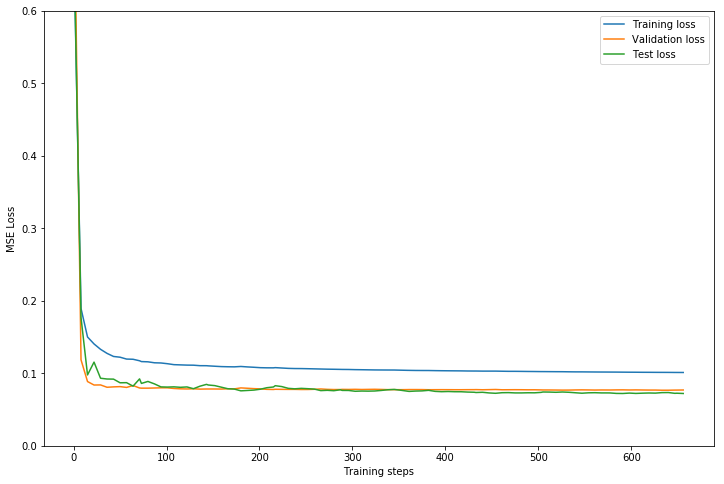

In [14]:
plt.figure(figsize=(12, 8 ))
plt.ylim([0, 0.6])
plt.xlabel("Training steps")
plt.ylabel("MSE Loss")
plt.plot(TRAINING_STEP, TRAIN_LOSS, label="Training loss")
plt.plot(TRAINING_STEP, VAL_LOSS, label="Validation loss")
plt.plot(TRAINING_STEP, TEST_LOSS, label="Test loss")
plt.legend() # Shows graph labels

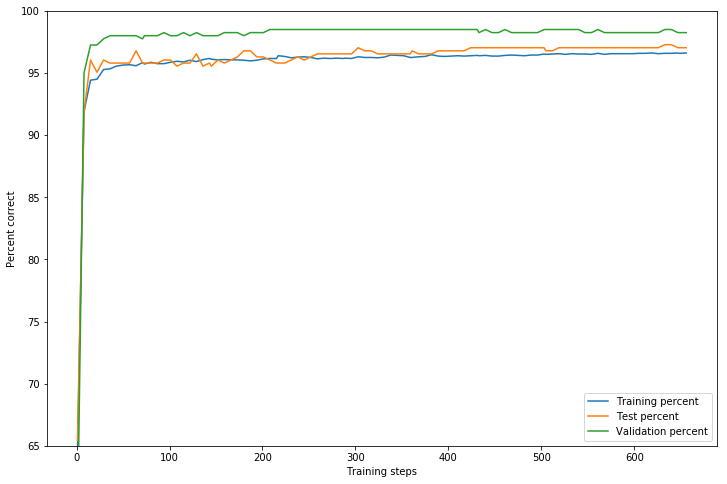

In [15]:
plt.figure(figsize=(12, 8 ))
plt.ylim([65, 100])
plt.xlabel("Training steps")
plt.ylabel("Percent correct")
plt.plot(TRAINING_STEP, TRAIN_CORRECT_PERCENT, label="Training percent")
plt.plot(TRAINING_STEP, TEST_CORRECT_PERCENT, label="Test percent")
plt.plot(TRAINING_STEP, VAL_CORRECT_PERCENT, label="Validation percent")

plt.legend() # Shows graph labels

In [16]:
#Regularized version
w = np.zeros((num_features, 1))

# Tracking variables


TRAIN_LOSS = []
VAL_LOSS = []
TEST_LOSS = []
TRAINING_STEP = []
TRAIN_CORRECT_PERCENT = []
TEST_CORRECT_PERCENT = []
VAL_CORRECT_PERCENT = []


def train_loop_regularized(w, reg_param):
  #print(w.shape)
  training_it = 0
  stop_condition_counter = 0
  for epoch in range(epochs):
    #shuffle(X_train, Y_train)
    X_train_c, Y_train_c = unison_shuffled_copies(X_train, Y_train)
    for i in range(num_batches_per_epoch):
      
      X_batch = X_train_c[i*batch_size:(i+1)*batch_size]
      Y_batch = Y_train_c[i*batch_size:(i+1)*batch_size]

      out = forward_pass(X_batch, w)
      learning_rate = anneal_learning_rate(training_it)
      w = gradient_decent_regularized(X_batch, out, Y_batch, w, learning_rate, regularization_lambda)
      #print(out)
      training_it += 1
      if i % check_step == 0:
        
        # Loss function values
        TRAINING_STEP.append(training_it)
        train_out = forward_pass(X_train, w)
        train_loss = cel_loss_regularized(Y_train, train_out, w, regularization_lambda)
        TRAIN_LOSS.append(train_loss)
        val_out = forward_pass(X_val, w)
        val_loss = cel_loss_regularized(Y_val, val_out, w, regularization_lambda)
        VAL_LOSS.append(val_loss)
        test_out = forward_pass(X_test, w)
        test_loss = cel_loss_regularized(Y_test, test_out, w, regularization_lambda)
        TEST_LOSS.append(test_loss)
        
        #plotting percentage of correct guesses
        train_correct = 0
        for i in range(Y_train.size):
            if (Y_train[i] == 1 and train_out[i] >= 0.5) or (Y_train[i] == 0 and train_out[i] < 0.5):
                train_correct +=1
        TRAIN_CORRECT_PERCENT.append((train_correct / Y_train.size)*100)
        test_correct = 0
        for i in range(Y_test.size):
            if (Y_test[i] == 1 and test_out[i] >= 0.5) or (Y_test[i] == 0 and test_out[i] < 0.5):
                test_correct +=1
        TEST_CORRECT_PERCENT.append((test_correct / Y_test.size)*100)
        val_correct = 0
        for i in range(Y_val.size):
            if (Y_val[i] == 1 and val_out[i] >= 0.5) or (Y_val[i] == 0 and val_out[i] < 0.5):
                val_correct +=1
        VAL_CORRECT_PERCENT.append((val_correct / Y_val.size)*100)
        
        
        
        if early_stop(VAL_LOSS):
            stop_condition_counter += 1
            if stop_condition_counter > 3:
                print("Early stopping Triggered!")
                print(training_it)
                return w
        else:
            stop_condition_counter = 0
            

  return w


#running multiple times with different regularization parameters
regularization_array = [0.01, 0.001, 0.0001]

VAL_CORRECT_ONE = []
TRAINING_STEP_ONE = []
VAL_CORRECT_TWO = []
TRAINING_STEP_TWO = []
VAL_CORRECT_THREE = []
TRAINING_STEP_THREE = []
for i in range(3):
    w = np.zeros((num_features, 1))
    w = train_loop_regularized(w, regularization_array[i])
    if i == 0:
        VAL_CORRECT_ONE = VAL_CORRECT_PERCENT
        TRAINING_STEP_ONE = TRAINING_STEP
    if i == 1:
        VAL_CORRECT_TWO = VAL_CORRECT_PERCENT
        TRAINING_STEP_TWO = TRAINING_STEP
    if i == 2:
        VAL_CORRECT_THREE = VAL_CORRECT_PERCENT
        TRAINING_STEP_THREE = TRAINING_STEP
    TRAIN_LOSS = []
    VAL_LOSS = []
    TEST_LOSS = []
    TRAINING_STEP = []
    TRAIN_CORRECT_PERCENT = []
    TEST_CORRECT_PERCENT = []
    VAL_CORRECT_PERCENT = []
    


Early stopping Triggered!
900
Early stopping Triggered!
115
Early stopping Triggered!
1109


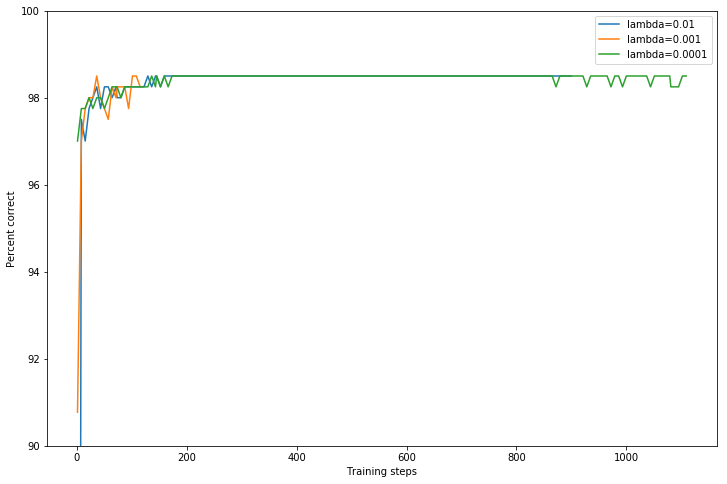

In [17]:
plt.figure(figsize=(12, 8 ))
plt.ylim([90, 100])
plt.xlabel("Training steps")
plt.ylabel("Percent correct")
plt.plot(TRAINING_STEP_ONE, VAL_CORRECT_ONE, label="lambda=0.01")
plt.plot(TRAINING_STEP_TWO, VAL_CORRECT_TWO, label="lambda=0.001")
plt.plot(TRAINING_STEP_THREE, VAL_CORRECT_THREE, label="lambda=0.0001")

plt.legend() # Shows graph labels